In [1]:
%%capture
%cd ../../
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm
from tqdm import tqdm

from make_clinical_dataset import ROOT_DIR
from make_clinical_dataset.constants import OBS_MAP
from make_clinical_dataset.preprocess.epr.lab import clean_lab_data
from make_clinical_dataset.preprocess.epr.opis import clean_drug_name, filter_treatment_data
from make_clinical_dataset.preprocess.epr.radiology import get_radiology_data
from make_clinical_dataset.util import load_included_drugs, load_included_regimens

pd.set_option('display.max_columns', 110)
pd.set_option('display.max_rows', 110)

In [3]:
# load external data
included_drugs = load_included_drugs()
included_regimens = load_included_regimens()

mrn_map = pd.read_csv(f'{ROOT_DIR}/data/external/MRN_map.csv')
mrn_map = mrn_map.set_index('RESEARCH_ID')['PATIENT_MRN'].to_dict()

# Lab Data

In [4]:
biochem = pd.read_parquet(f'{ROOT_DIR}/data/raw/biochemistry.parquet.gzip')
hema = pd.read_parquet(f'{ROOT_DIR}/data/raw/hematology.parquet.gzip')
lab_data = {'Hematology': hema, 'Biochemistry': biochem}

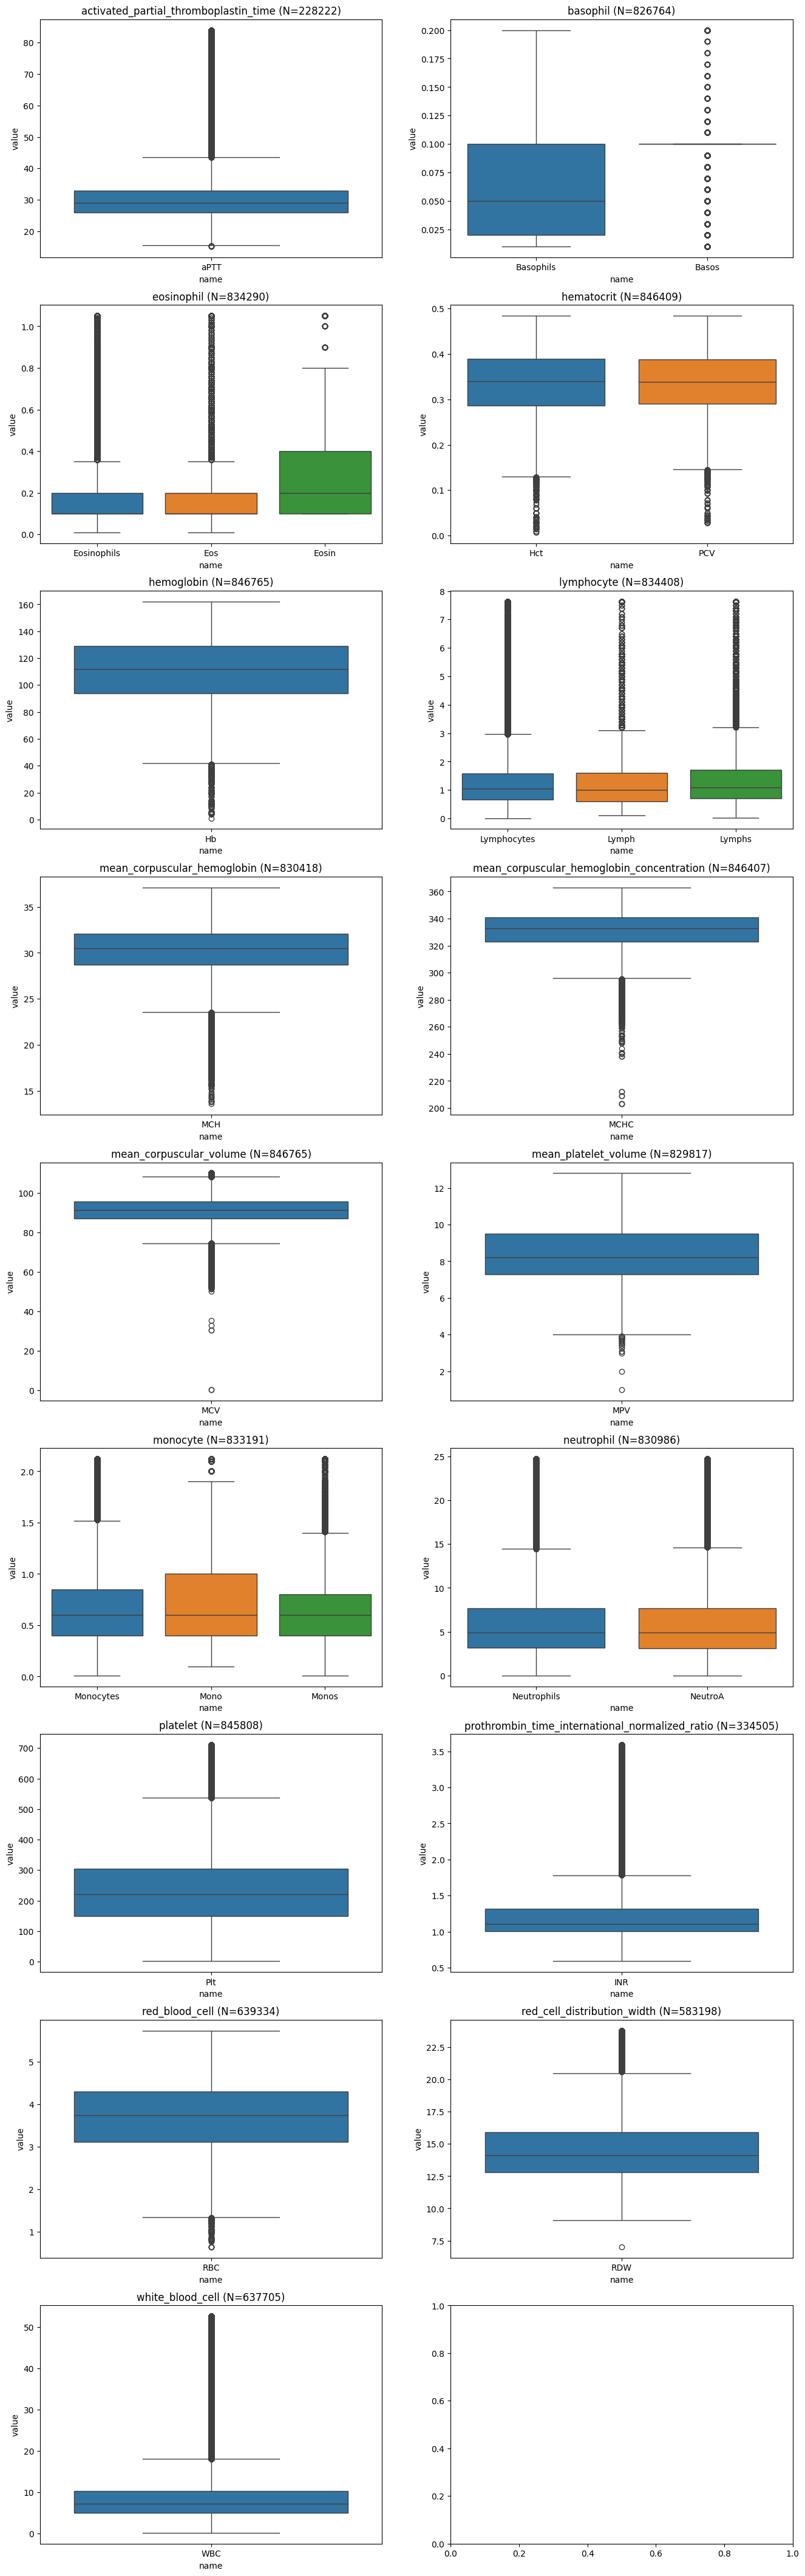

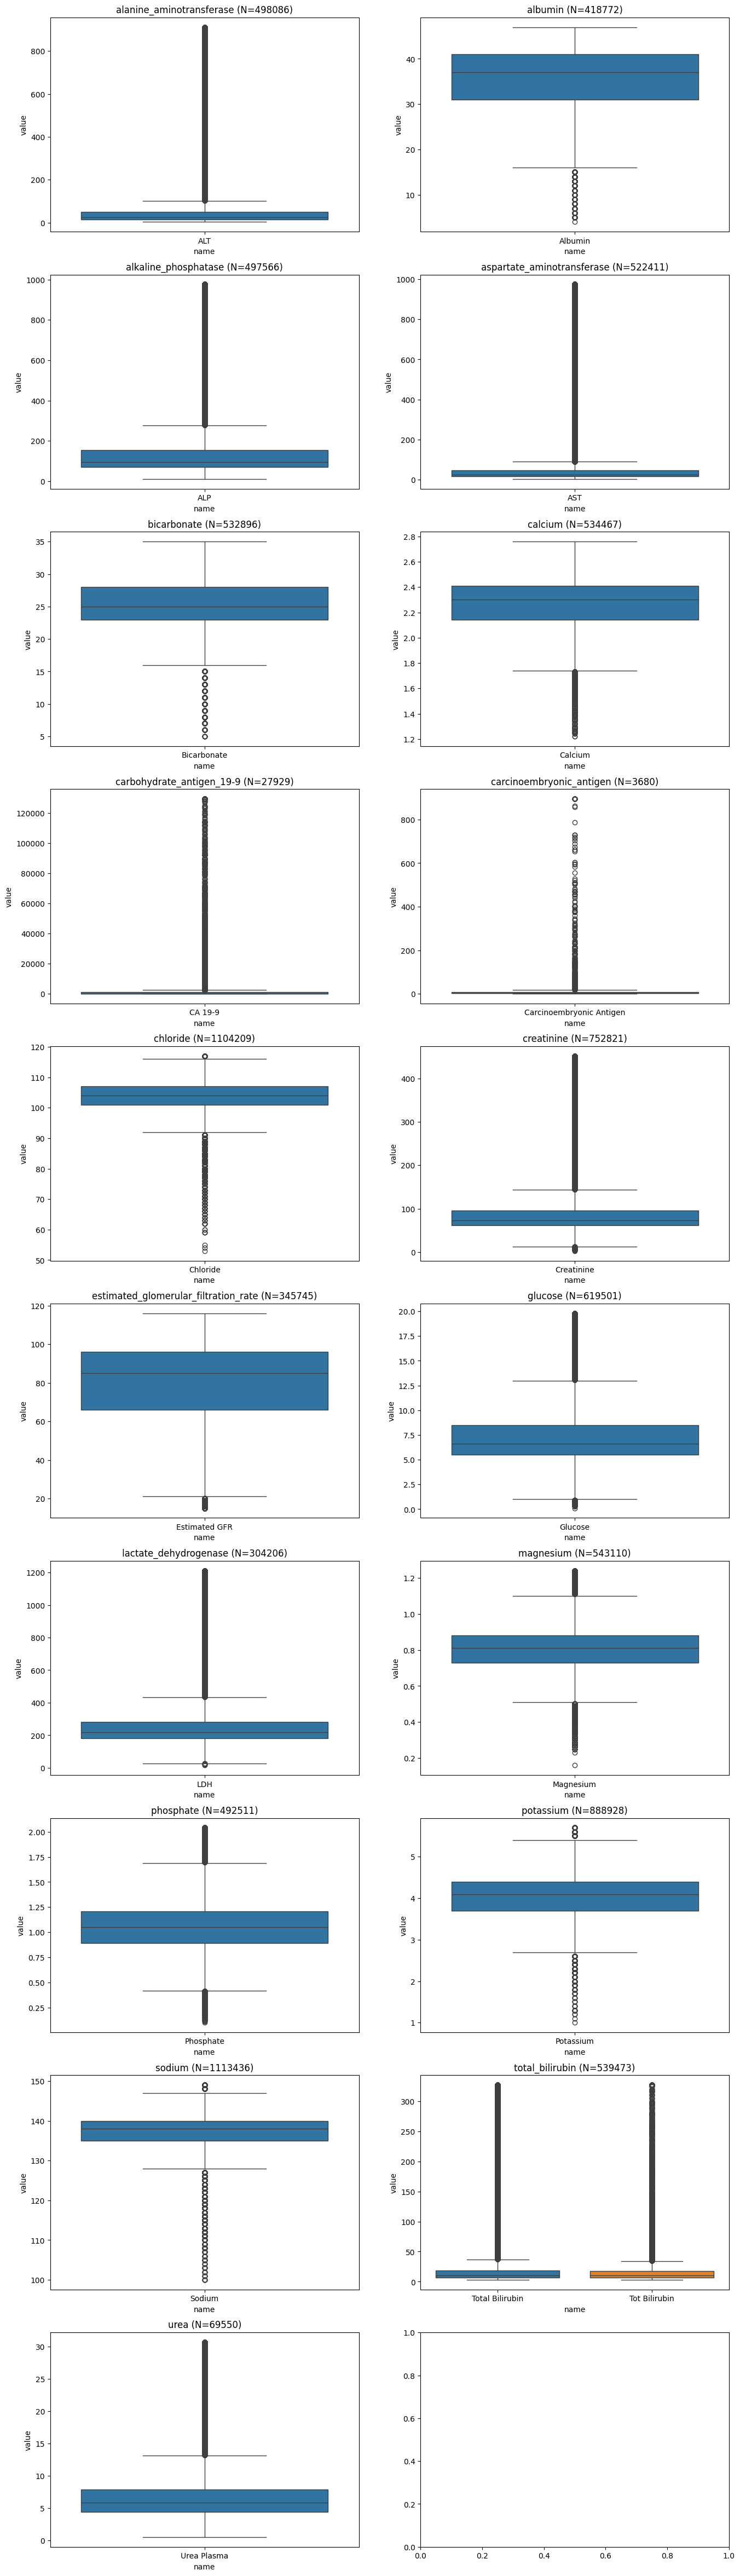

In [ ]:
"""
Check out the lab name groupings
"""
for lab_name, df in lab_data.items():
    assert not (df['component-code-coding-0-display'].notnull() & df['component-code-text'].notnull()).any()
    df['name'] = df['component-code-coding-0-display'].fillna(df['component-code-text'])
    df['group'] = df['name'].map(OBS_MAP[lab_name])
    df['value'] = df['component-valueQuantity-value']

    vals = OBS_MAP[lab_name].values()
    nrows, ncols = df['group'].nunique() // 2 + 1, 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8*ncols, 6*nrows))
    axes = axes.flatten()
    i = 0
    for name, group in df.groupby('group'):
        group['value'] = group['value'].clip(upper=group['value'].quantile(0.99))
        palette = sns.color_palette('husl', group['name'].nunique())
        sns.boxplot(data=group, x="name", y="value", ax=axes[i], hue="name")
        axes[i].set(title=f'{name} (N={len(group)})')
        i += 1

    # store the original lab names
    # df['name'].value_counts().to_csv(f'{ROOT_DIR}/data/interim/{lab_name.lower()}_lab_names.csv')

## 'component-code-coding-0-display' vs 'component-code-text'
NOTE: also the timestamp format differs based on which column is used

In [5]:
for lab_name, df in lab_data.items():
    df = clean_lab_data(df)
    df = df[df['obs_value'].notnull()]
    df['obs_display'] = df['obs_display'].map(OBS_MAP[lab_name])
    df['obs_text'] = df['obs_text'].map(OBS_MAP[lab_name])
    assert df['obs_display'].nunique() == df['obs_text'].nunique()
    lab_data[lab_name] = df

### compare process codes between the two

In [6]:
df = lab_data['Hematology']
print(df.groupby('obs_display')['proc_name'].value_counts())
print('#'*100)
print(df.groupby('obs_text')['proc_name'].value_counts())

obs_display                                      proc_name                                  
activated_partial_thromboplastin_time            aPTT                                           170730
basophil                                         CBC                                            245883
eosinophil                                       CBC                                            470165
                                                 Blood Film Review (Lab Orderable)                8925
                                                 Fluid, Cell Count and Differential                543
                                                 Synovial Fluid, Cell Count and Differential         8
hematocrit                                       CBC                                            586517
                                                 Blood Film Review (Lab Orderable)               15937
hemoglobin                                       CBC                               

In [7]:
df = lab_data['Biochemistry']
print(df.groupby('obs_display')['proc_name'].value_counts())
print('#'*100)
print(df.groupby('obs_text')['proc_name'].value_counts())

obs_display                           proc_name                                          
alanine_aminotransferase              ALT                                                    363166
albumin                               Albumin, Plasma                                        279196
                                      Albumin, fluid                                            866
alkaline_phosphatase                  ALP                                                    364047
aspartate_aminotransferase            AST                                                    364386
bicarbonate                           Bicarbonate, Plasma                                    209468
                                      Anion Gap                                              148178
                                      Bicarbonate, fluid                                          7
calcium                               Calcium Total, Plasma                                  353681
          

### compare lab units between the two

In [8]:
df = lab_data['Hematology']
print(df.groupby('obs_display')['obs_unit'].value_counts())
print('#'*100)
print(df.groupby('obs_text')['obs_unit'].value_counts())

obs_display                                obs_unit
activated_partial_thromboplastin_time      s           170730
basophil                                   x10e9/L     245883
eosinophil                                 x10e9/L     330305
                                           bil/L         8925
                                           %              388
hematocrit                                 L/L         602454
hemoglobin                                 g/L         602825
lymphocyte                                 x10e9/L     382054
                                           bil/L        16193
                                           %             2571
mean_corpuscular_hemoglobin                pg          586406
mean_corpuscular_hemoglobin_concentration  g/L         602296
mean_corpuscular_volume                    fL          387292
                                           fl          215342
mean_platelet_volume                       fL          580828
monocyte          

In [9]:
df = lab_data['Biochemistry']
print(df.groupby('obs_display')['obs_unit'].value_counts())
print('#'*100)
print(df.groupby('obs_text')['obs_unit'].value_counts())

obs_display                           obs_unit     
alanine_aminotransferase              U/L              363166
albumin                               g/L              280062
alkaline_phosphatase                  U/L              364047
aspartate_aminotransferase            U/L              364386
bicarbonate                           mmol/L           357653
calcium                               mmol/L           374081
carbohydrate_antigen_19-9             kU/L              14458
carcinoembryonic_antigen              ug/L               2566
chloride                              mmol/L           771653
creatinine                            umol/L           533687
                                      mmol/d              135
                                      mmol/CP               1
estimated_glomerular_filtration_rate  mL/min/1.73m2    122727
glucose                               mmol/L           418855
lactate_dehydrogenase                 U/L              207621
magnesium         

### Observation value distribution

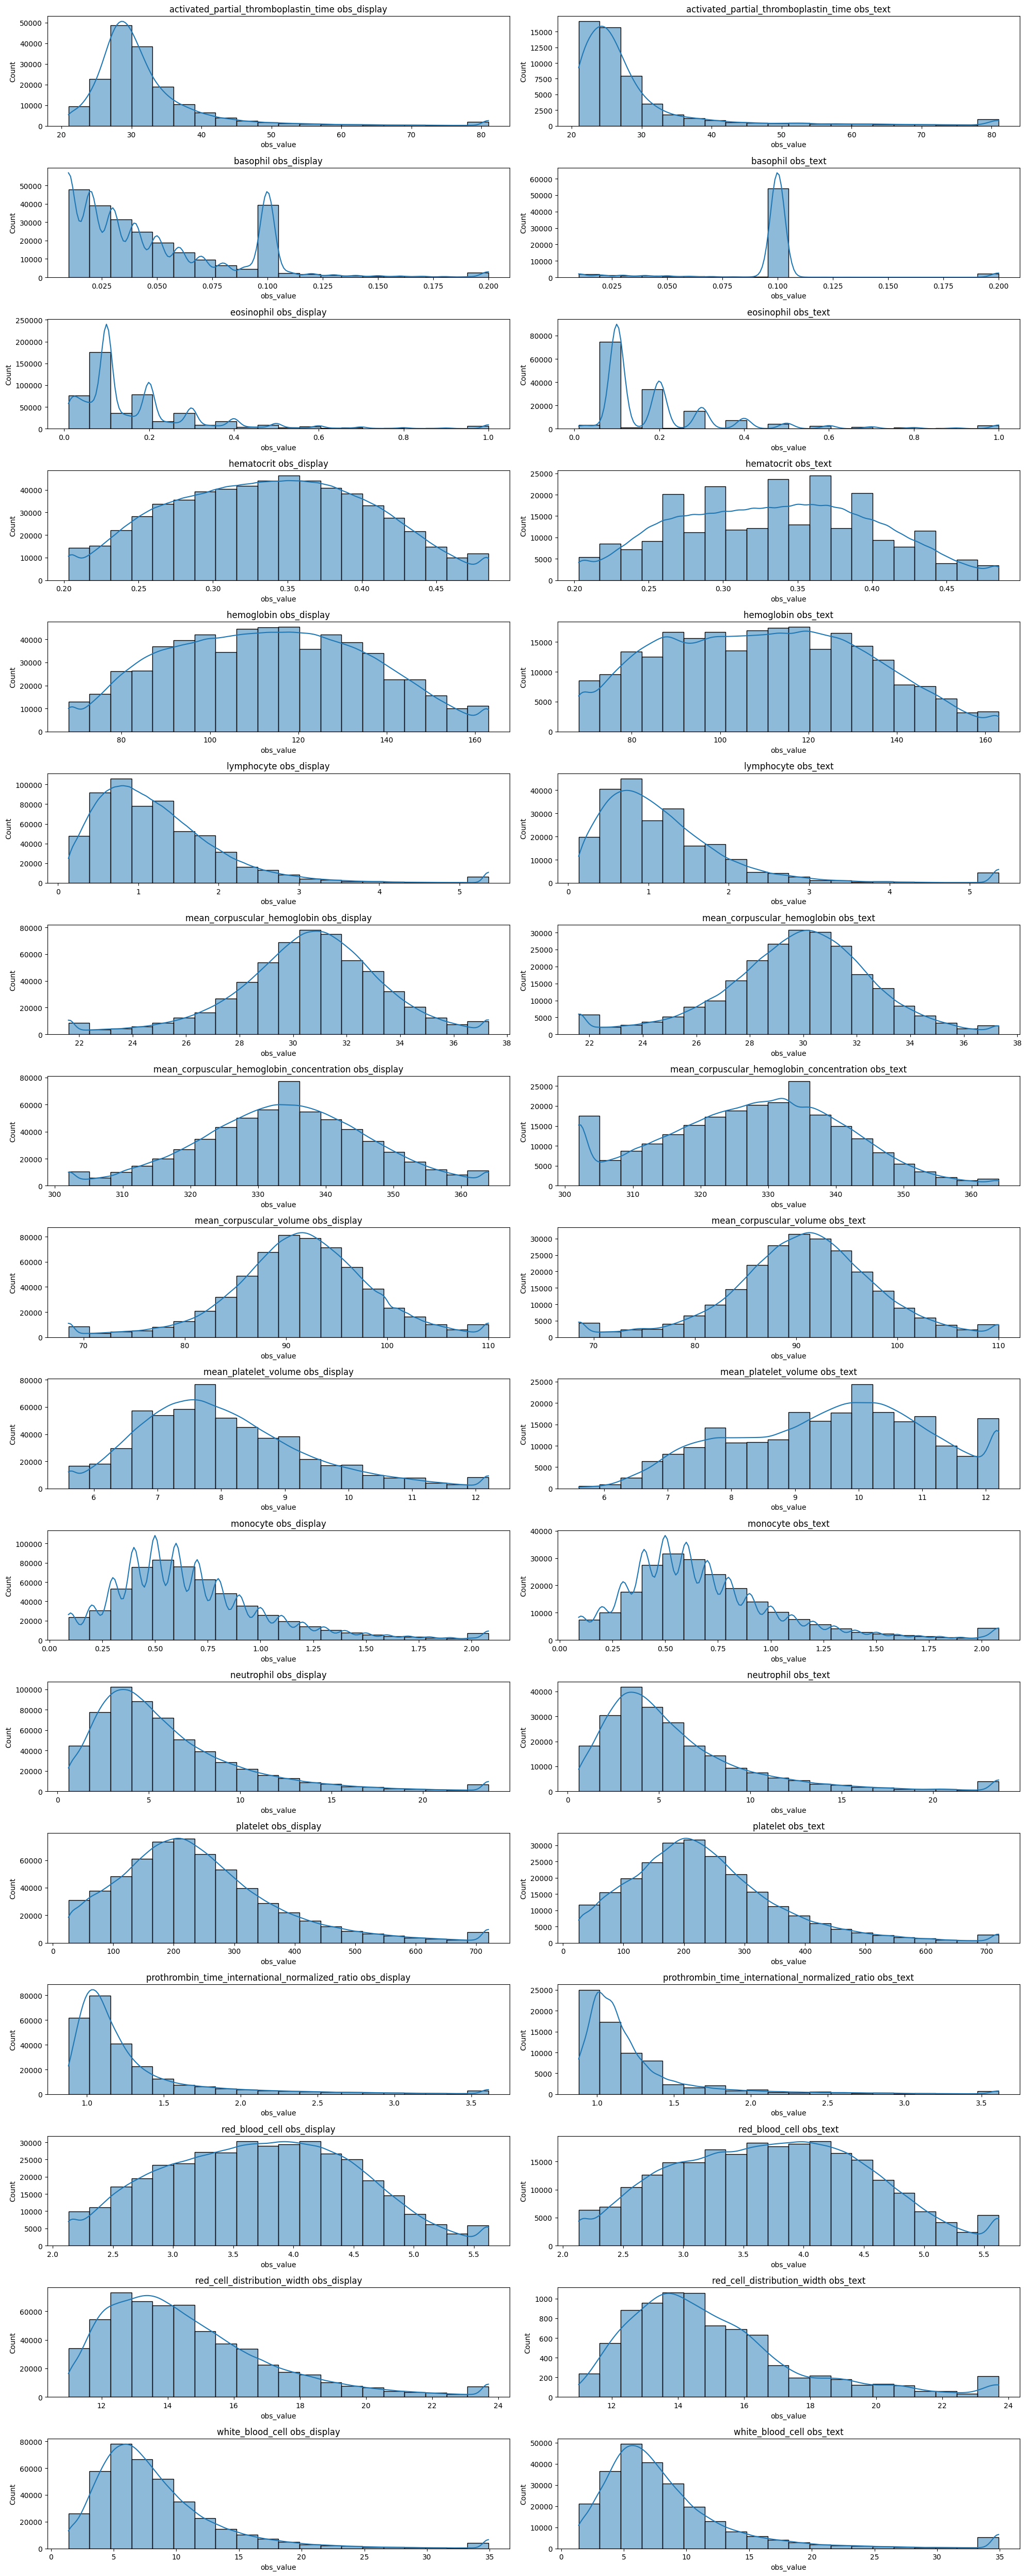

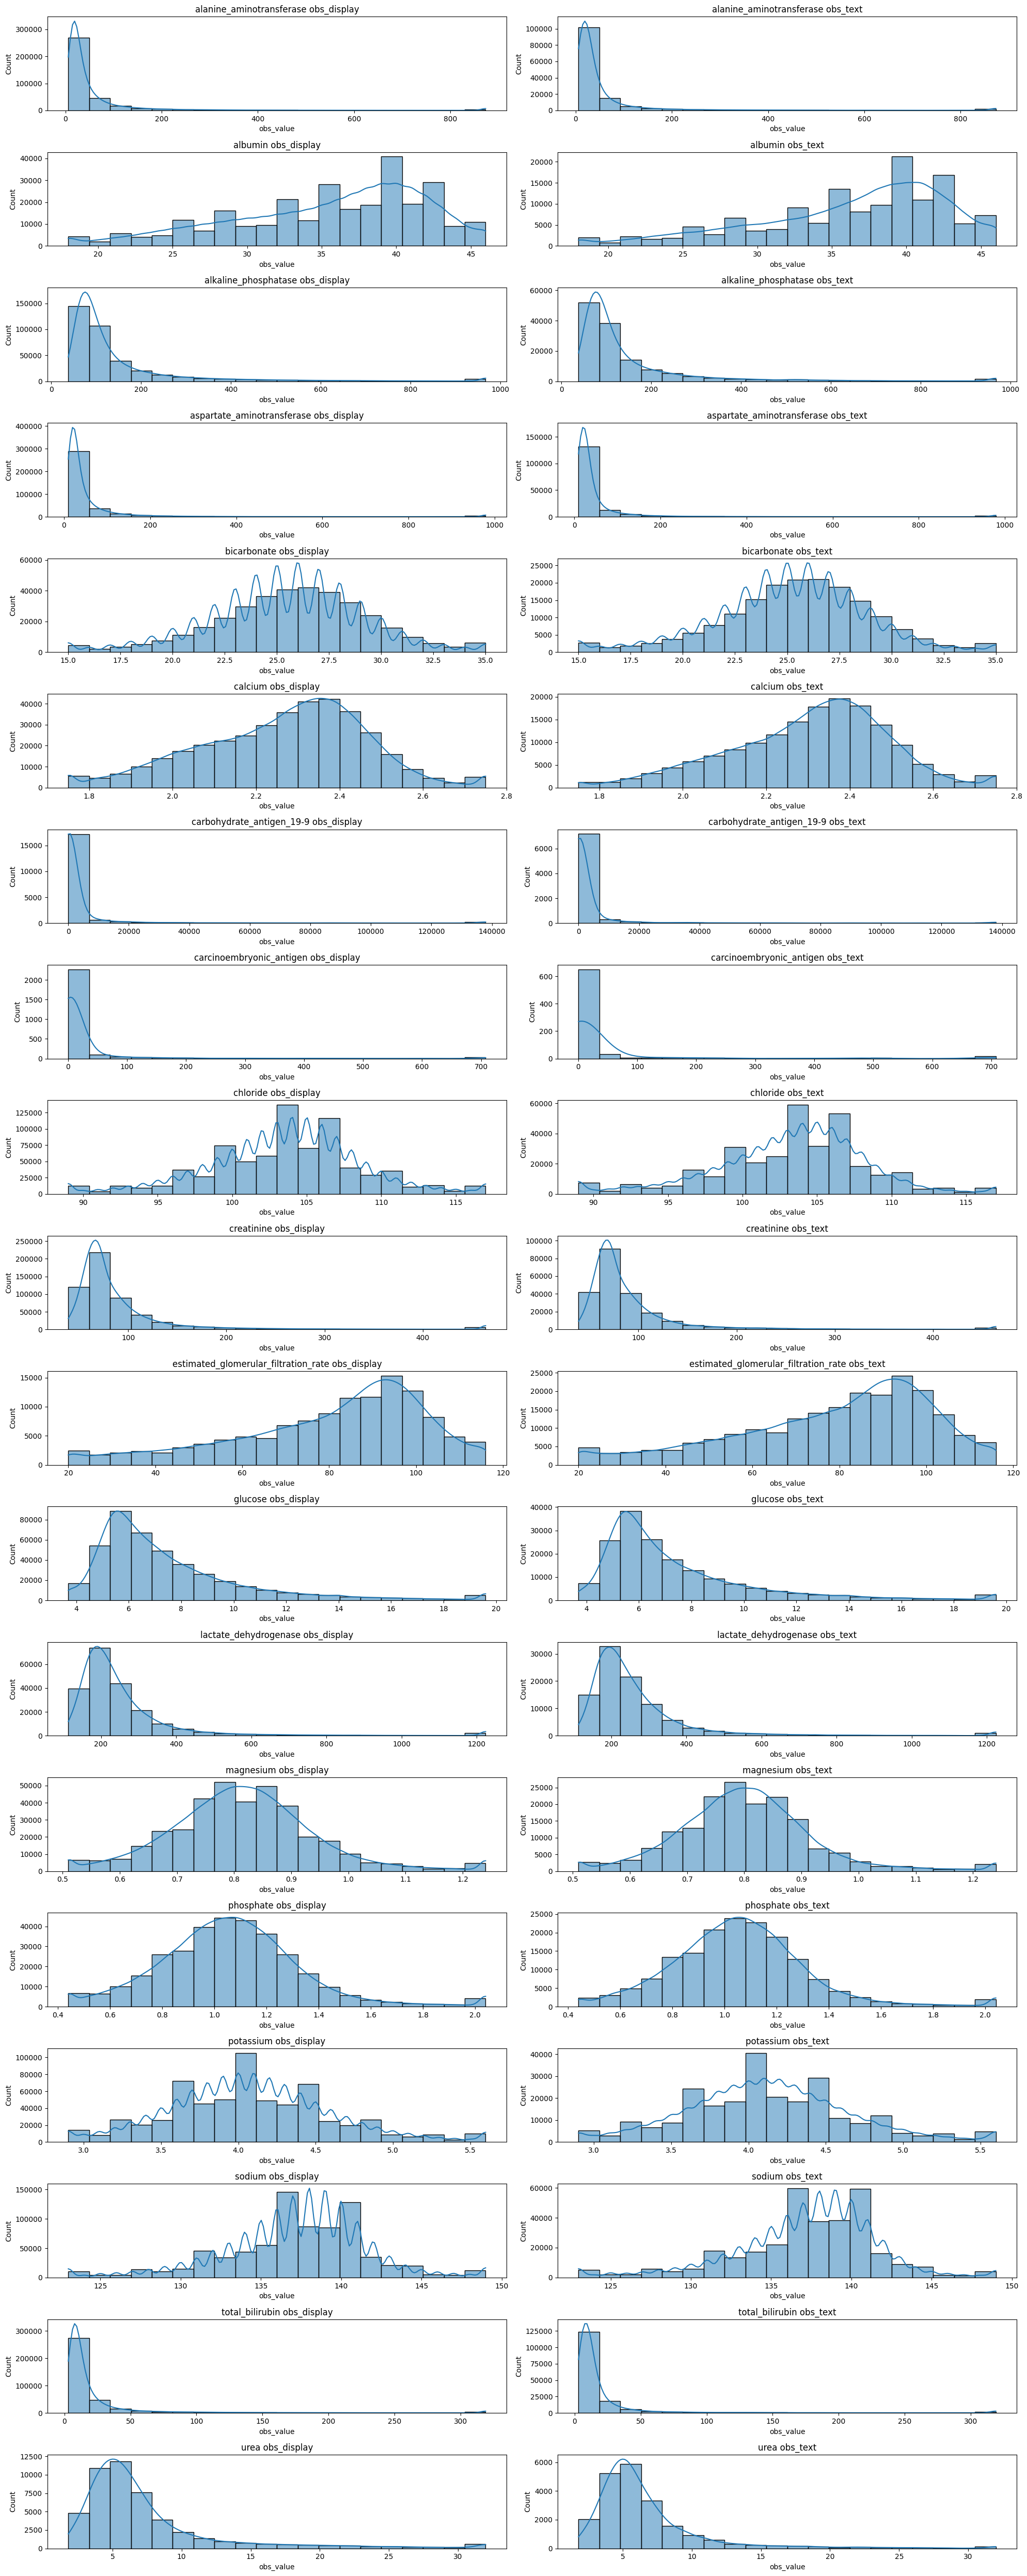

In [10]:
for lab_name, df in lab_data.items():
    fig, axes = plt.subplots(nrows=df['obs_display'].nunique(), ncols=2, figsize=(20,50))
    clip_thresh = {}
    for col_idx, col in enumerate(['obs_display', 'obs_text']):
        tmp = df[df[col].notnull()]
        for row_idx, (obs_name, obs_value) in enumerate(tmp['obs_value'].groupby(tmp[col])):
            ax = axes[row_idx, col_idx]
            if obs_name not in clip_thresh: 
                clip_thresh[obs_name] = (obs_value.quantile(0.01), obs_value.quantile(0.99))
            obs_value = obs_value.clip(*clip_thresh[obs_name])
            sns.histplot(obs_value, bins=20, kde=True, ax=ax)
            ax.set(title=f'{obs_name} {col}')
    plt.tight_layout()

## Measurement count over time

/var/folders/z4/8_5mvcb50jb15r8l3sl1qj4m0000gn/T/ipykernel_79338/713800977.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  counts = lab.groupby('obs_year').apply(lambda g: g[cols].notnull().sum())


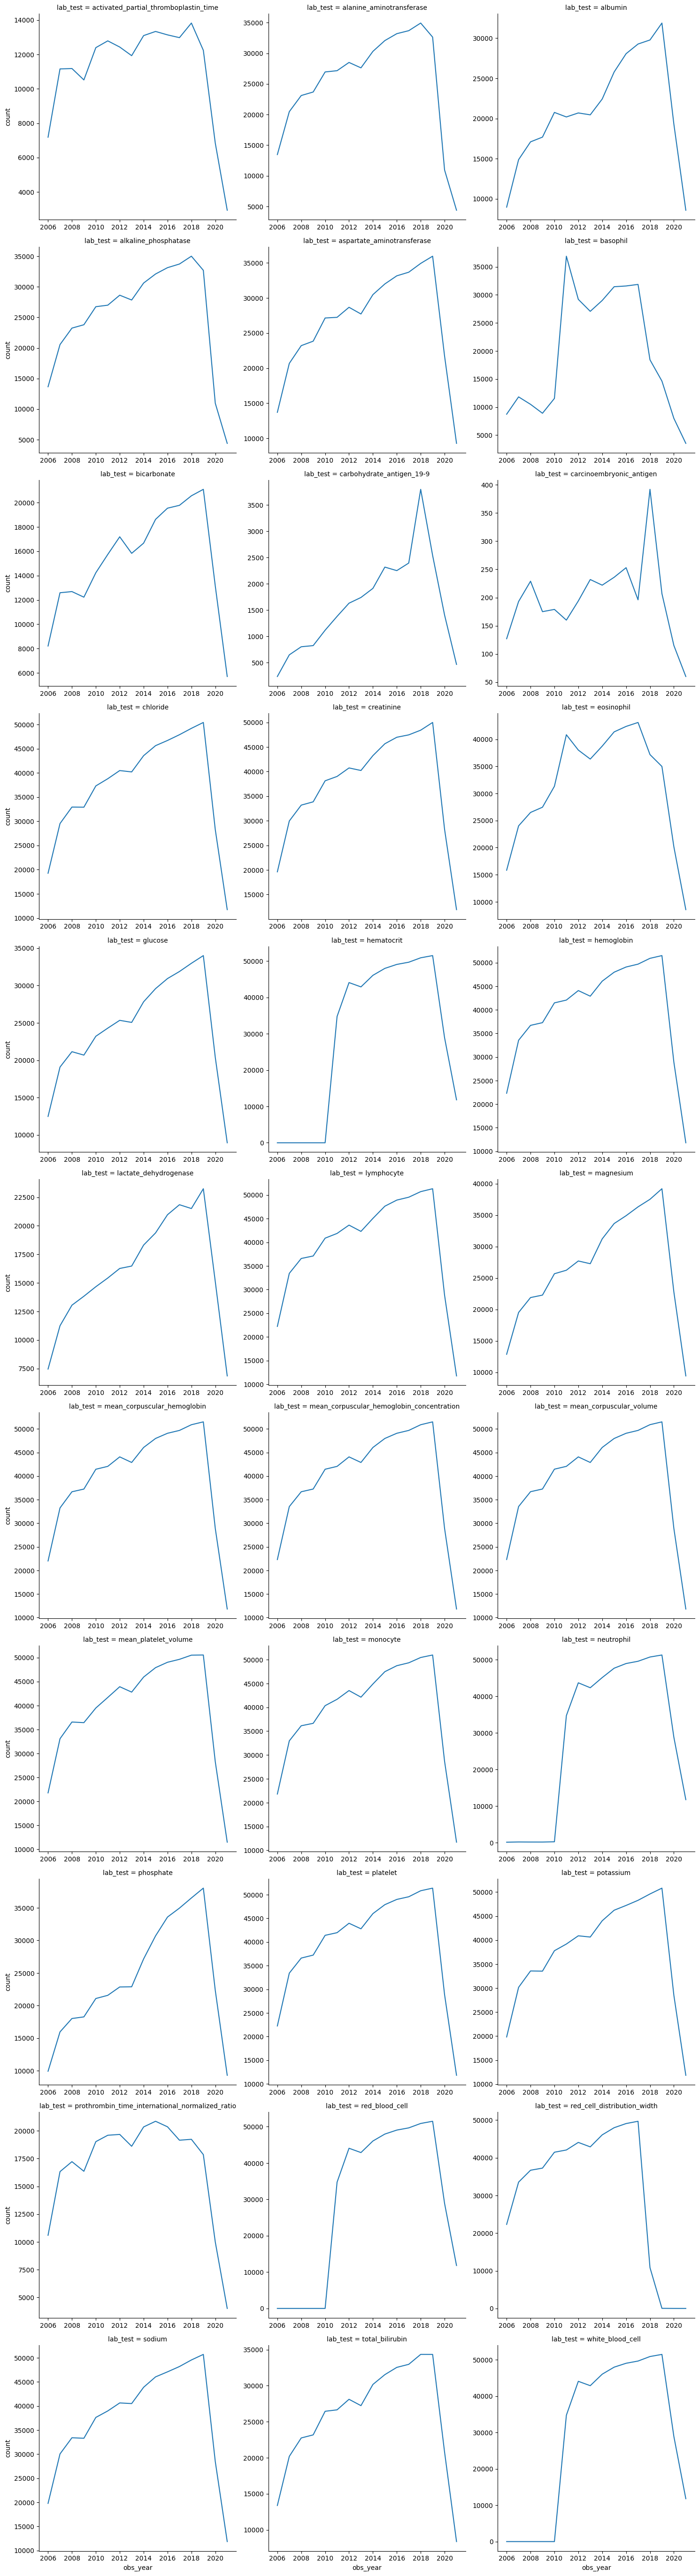

In [11]:
lab = pd.read_parquet(f'{ROOT_DIR}/data/interim/lab.parquet.gzip')
lab['obs_year'] = pd.to_datetime(lab['obs_date']).dt.year
cols = lab.columns.drop(['mrn', 'obs_year', 'obs_date'])
counts = lab.groupby('obs_year').apply(lambda g: g[cols].notnull().sum())
counts = counts.reset_index().melt('obs_year', var_name='lab_test', value_name='count')
g = sns.relplot(
    data=counts, x='obs_year', y='count', col='lab_test', col_wrap=3, kind='line', 
    facet_kws={'sharex': False, 'sharey': False}
)

# Symptom Data

In [16]:
dart = pd.read_parquet(f'{ROOT_DIR}/data/raw/dart.parquet.gzip')
symp = pd.read_parquet(f'{ROOT_DIR}/data/interim/symptom.parquet.gzip')

## Measurement count over time

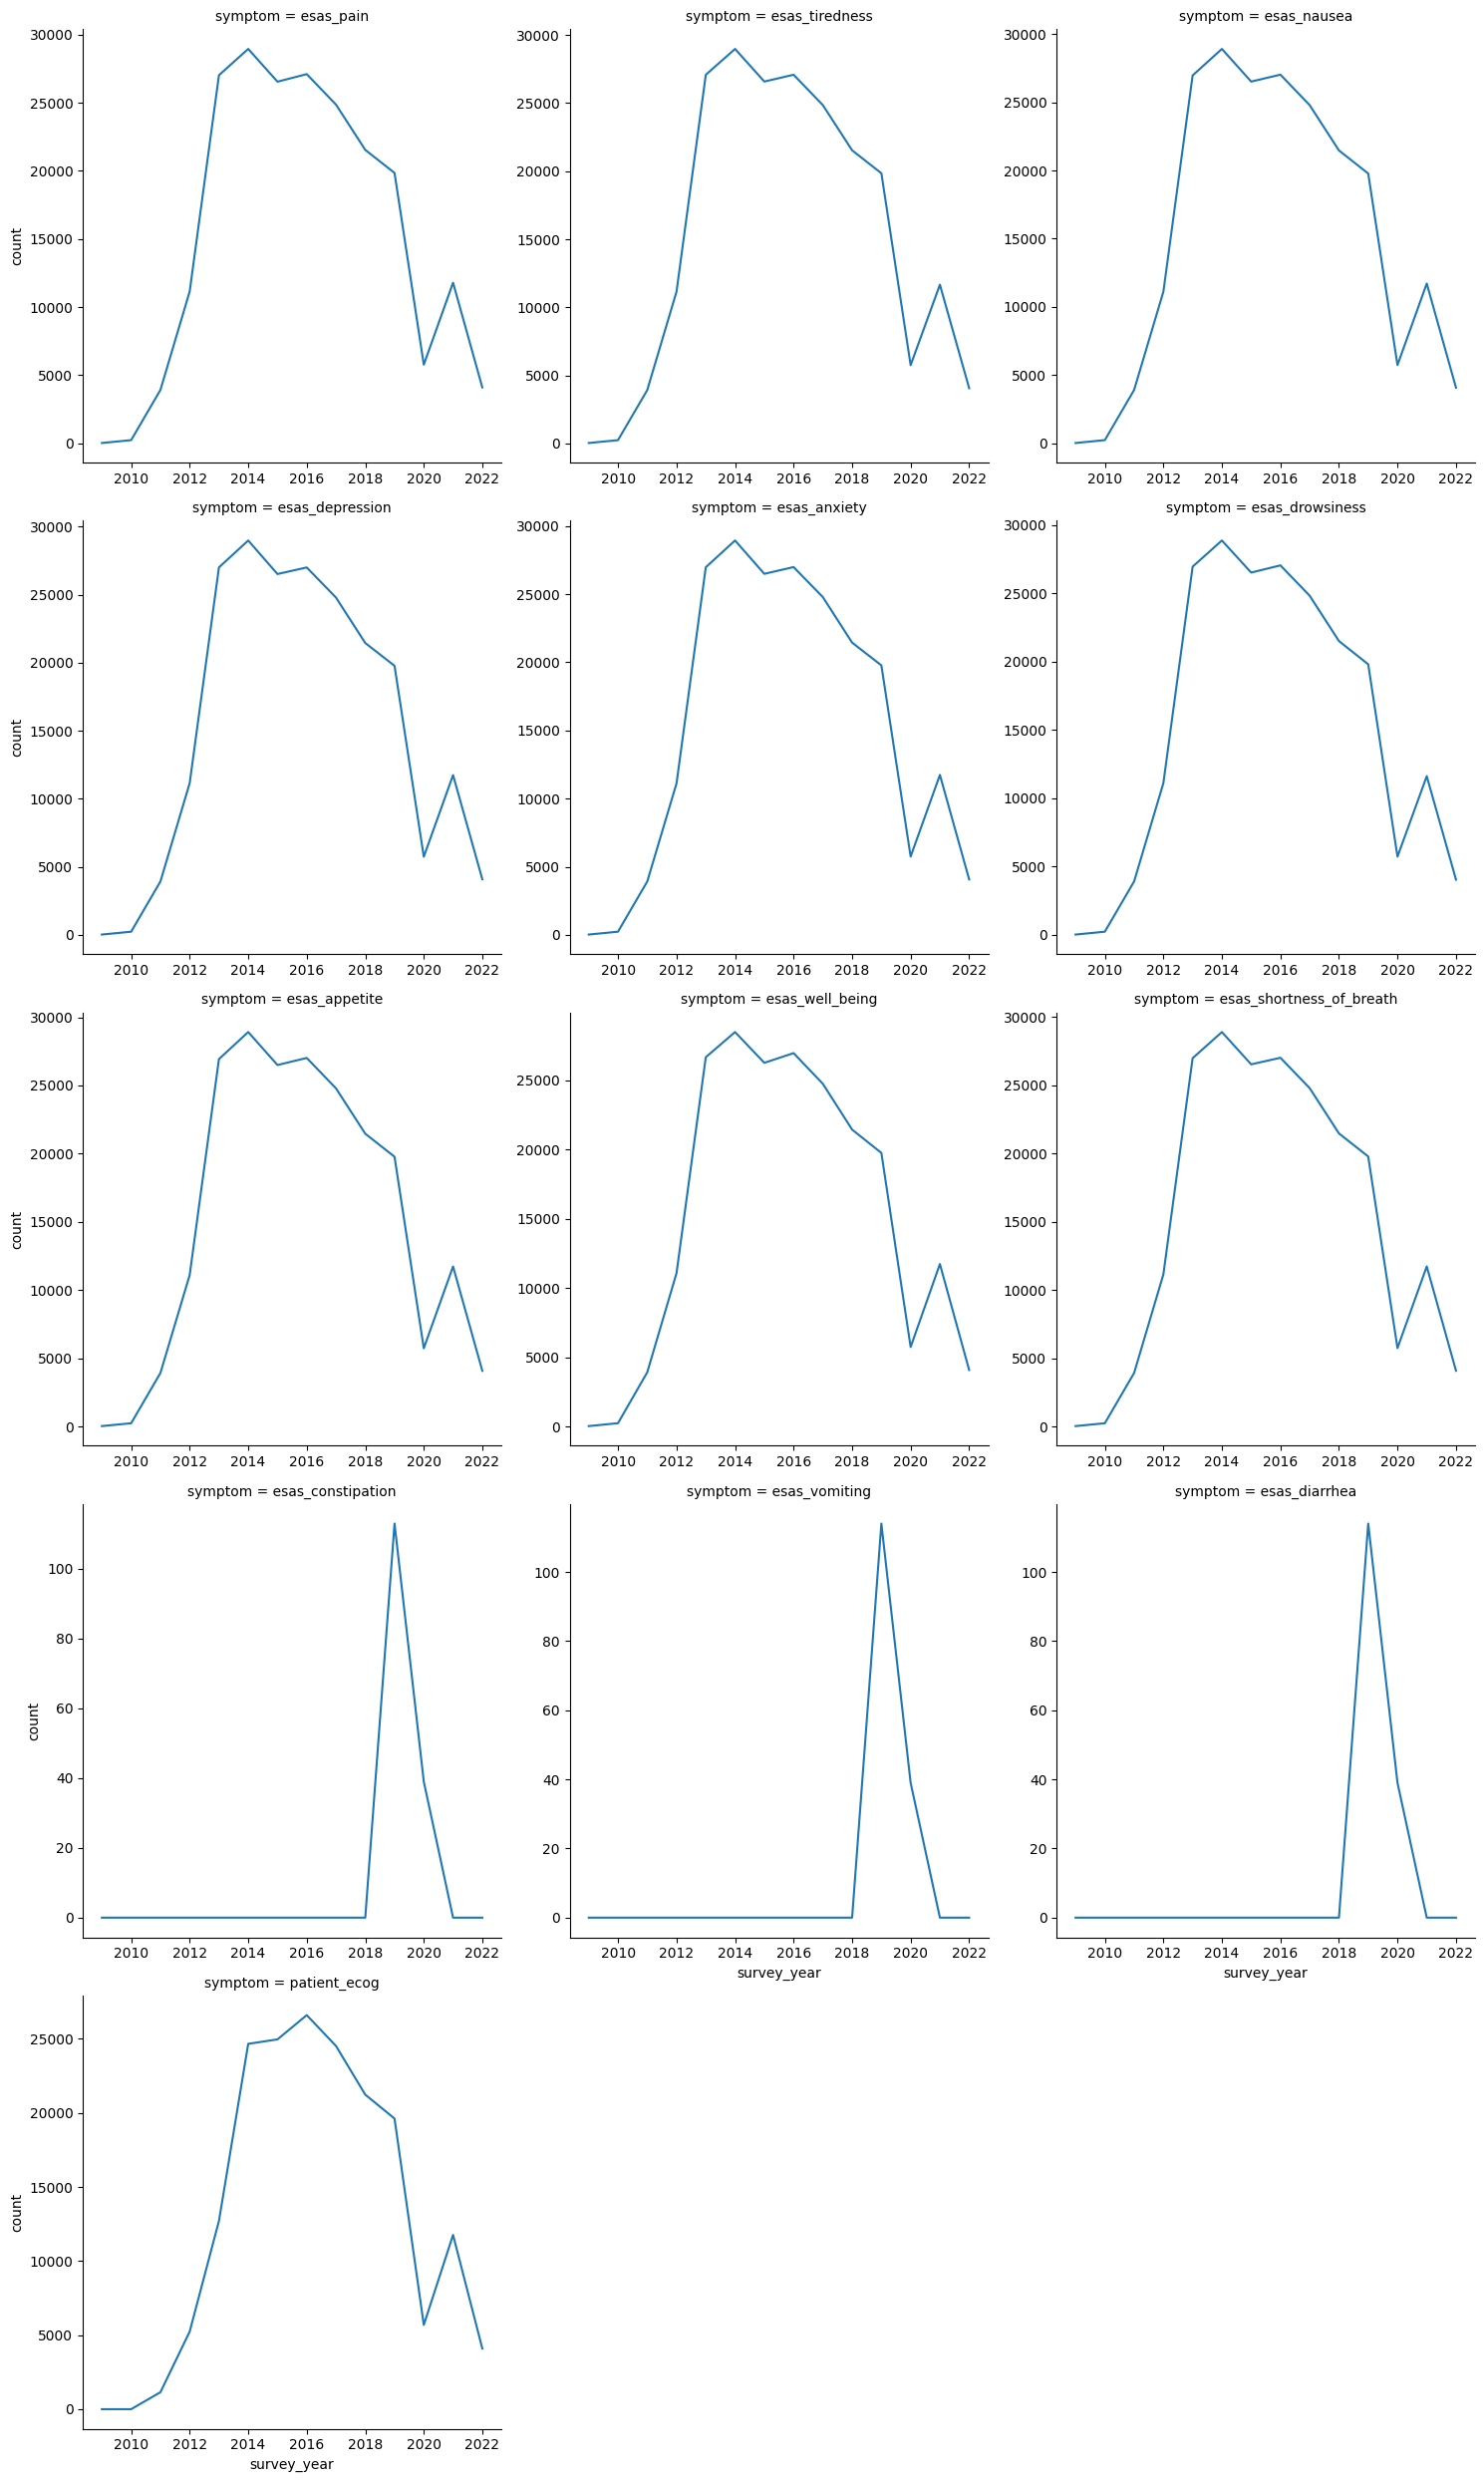

In [9]:
symp['survey_year'] = pd.to_datetime(symp['survey_date']).dt.year
cols = symp.columns.drop(['mrn', 'survey_year', 'survey_date'])
counts = symp.groupby('survey_year').apply(lambda g: g[cols].notnull().sum())
counts = counts.reset_index().melt('survey_year', var_name='symptom', value_name='count')
g = sns.relplot(
    data=counts, x='survey_year', y='count', col='symptom', col_wrap=3, kind='line', 
    facet_kws={'sharex': False, 'sharey': False}
)

## Score distribution

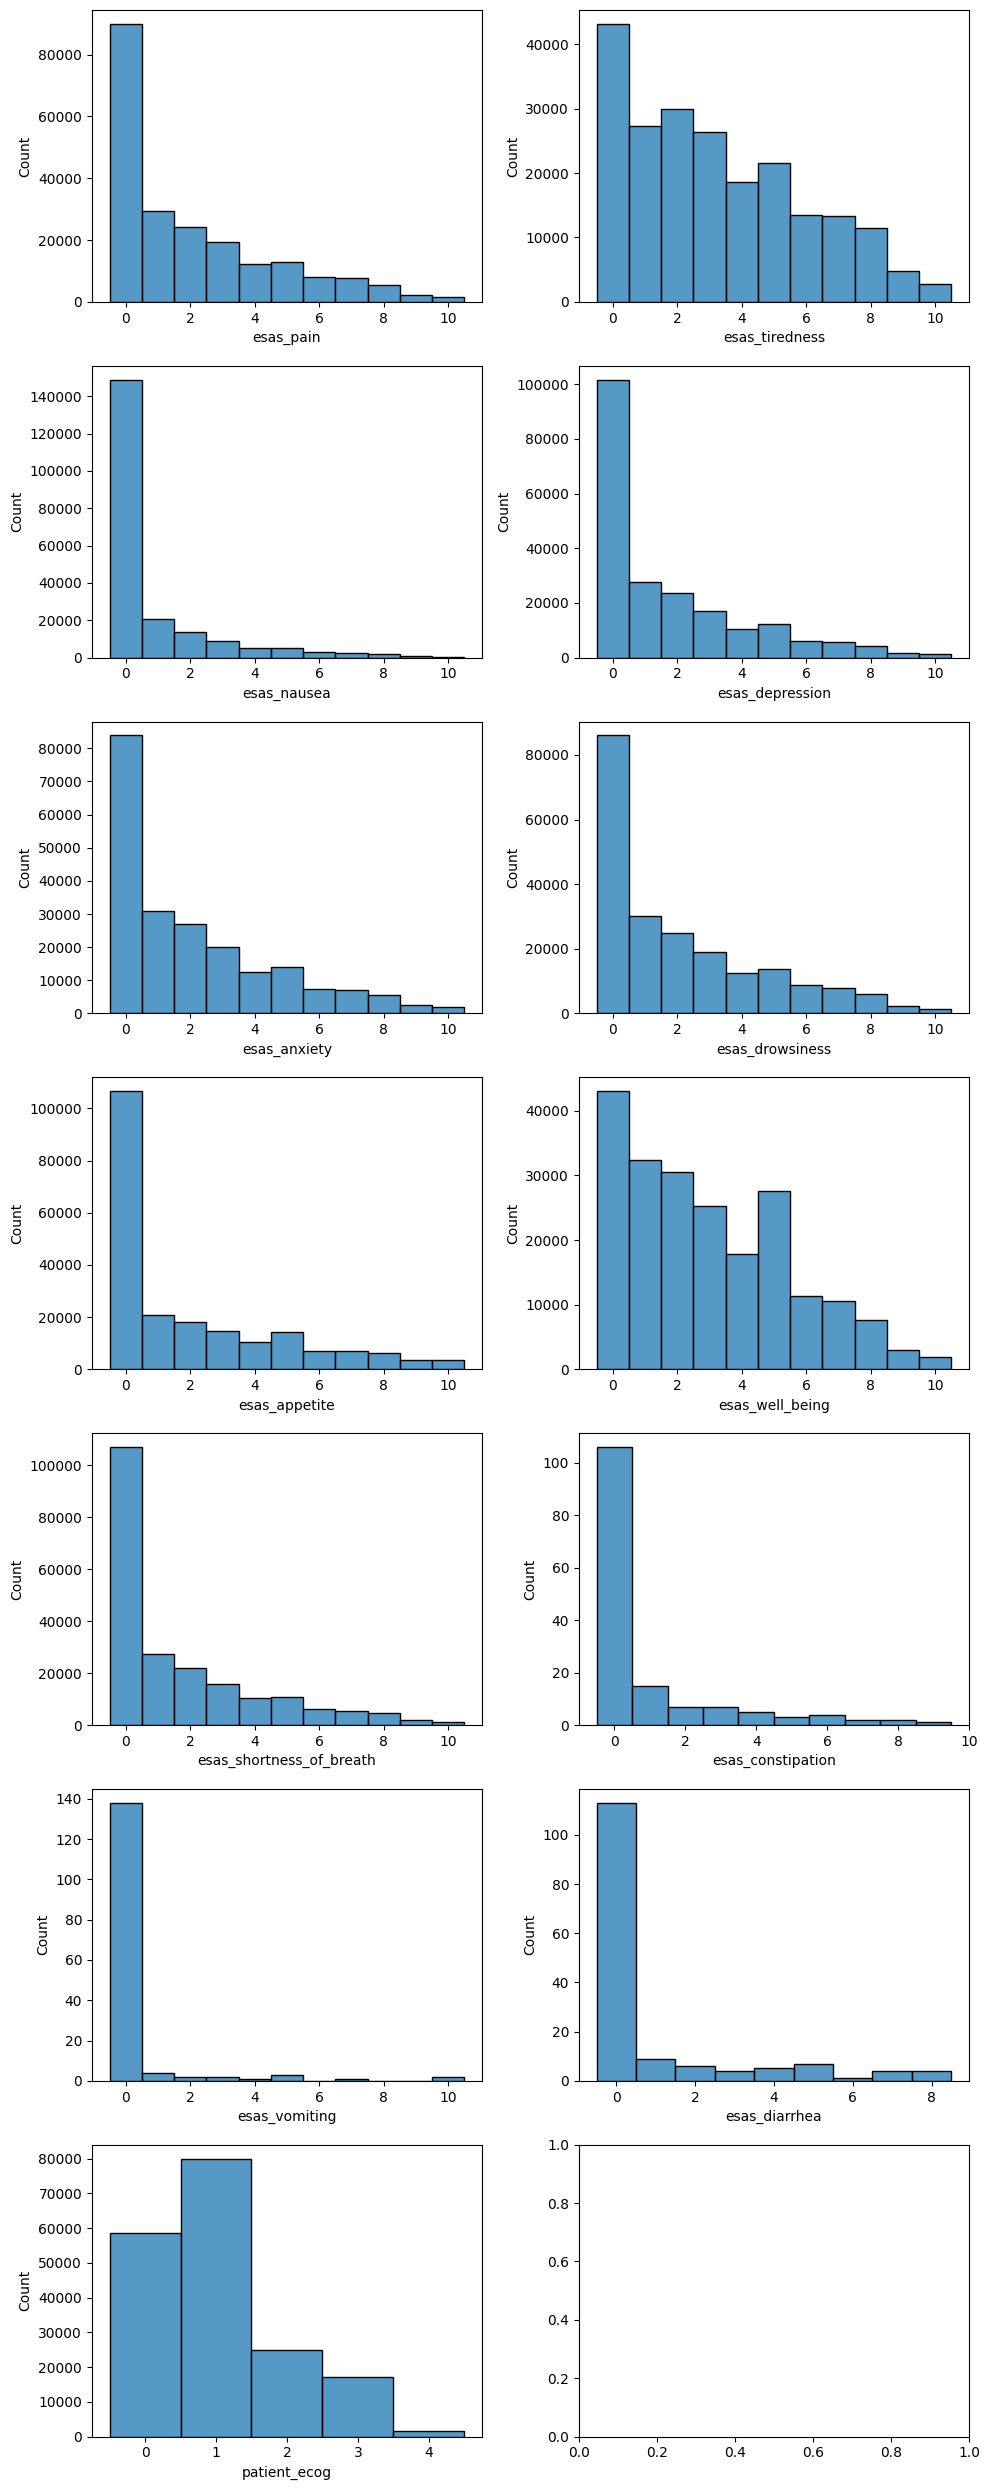

In [28]:
fig, axes = plt.subplots(nrows=int(np.ceil(len(cols)/2)), ncols=2, figsize=(10,25))
axes = axes.flatten()
for idx, col in enumerate(cols): 
    sns.histplot(symp[col], ax=axes[idx], discrete=True)
plt.tight_layout()

## Compare demographic info with cancer registry

In [68]:
canc_reg = pd.read_parquet(f'{ROOT_DIR}/data/raw/cancer_registry.parquet.gzip')
mrns = list(set(canc_reg['MEDICAL_RECORD_NUMBER']).intersection(dart['MRN']))
canc_reg_sex = canc_reg.groupby('MEDICAL_RECORD_NUMBER')['SEX'].unique()[mrns]
dart_sex = dart.groupby('MRN')['GENDER'].unique()[mrns]
mrns_with_conflict = [mrn for mrn in mrns if any(canc_reg_sex[mrn] != dart_sex[mrn]) or len(dart_sex[mrn]) > 1]
print(f'{len(mrns_with_conflict)} patients with conflicting sex info out of {len(dart_sex)} overlapping patients')

503 patients with conflicting sex info out of 27141 overlapping patients


# Treatment Data

In [6]:
opis = pd.read_parquet(f'{ROOT_DIR}/data/raw/opis.parquet.gzip')
trt = pd.read_parquet(f'{ROOT_DIR}/data/interim/treatment.parquet.gzip')

## Intent

In [ ]:
"""
Usually, after palliative intent treatment, rest of the treatment remains palliative.

Check the number of cases where that is not true.
"""
def check_intent_stays_palliative(df):
    mask = df['intent'] == 'PALLIATIVE'
    if not mask.any():
        return True
    idx = mask[mask].index[0]
    return all(mask.loc[idx:])

mask = trt.groupby('mrn').apply(check_intent_stays_palliative)
mask.value_counts()

True     10193
False      122
dtype: int64

<Axes: xlabel='treatment_year'>

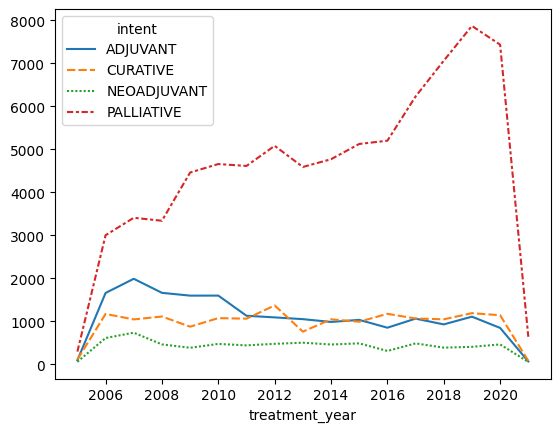

In [33]:
"""Number of treatments over time"""
trt['treatment_year'] = trt['treatment_date'].dt.year
counts = trt.groupby('treatment_year')['intent'].value_counts()
counts = pd.DataFrame(counts).rename(columns={'intent': 'count'}).reset_index()
counts = counts.pivot(index='treatment_year', columns='intent', values='count')
sns.lineplot(data=counts)

## First Treatment Date

In [ ]:
"""
Usually, the first treatment date is monotonically increasing (patients do not continue old treatment after starting new treatment)

Check the number of cases where that is not true.
"""
mask = trt.groupby('mrn').apply(lambda g: all(g['first_treatment_date'] == sorted(g['first_treatment_date'])))
mask.value_counts()

True     10109
False      206
dtype: int64

## Height and Weight

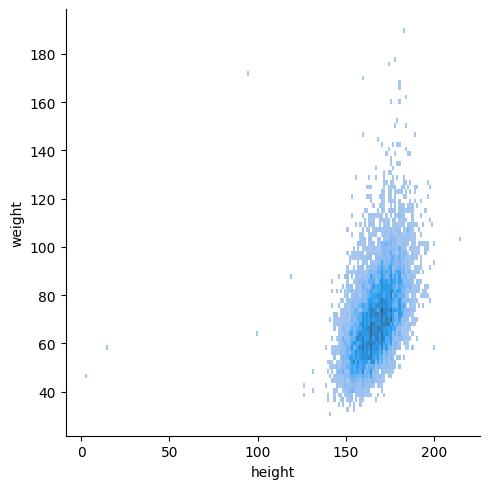

In [42]:
"""Height/weight distribution of patients undertaking treatment""" 
height_and_weight = trt.groupby('mrn').agg({'height': 'mean', 'weight': 'mean'})
sns.displot(data=height_and_weight, x='height', y='weight')

## Drugs

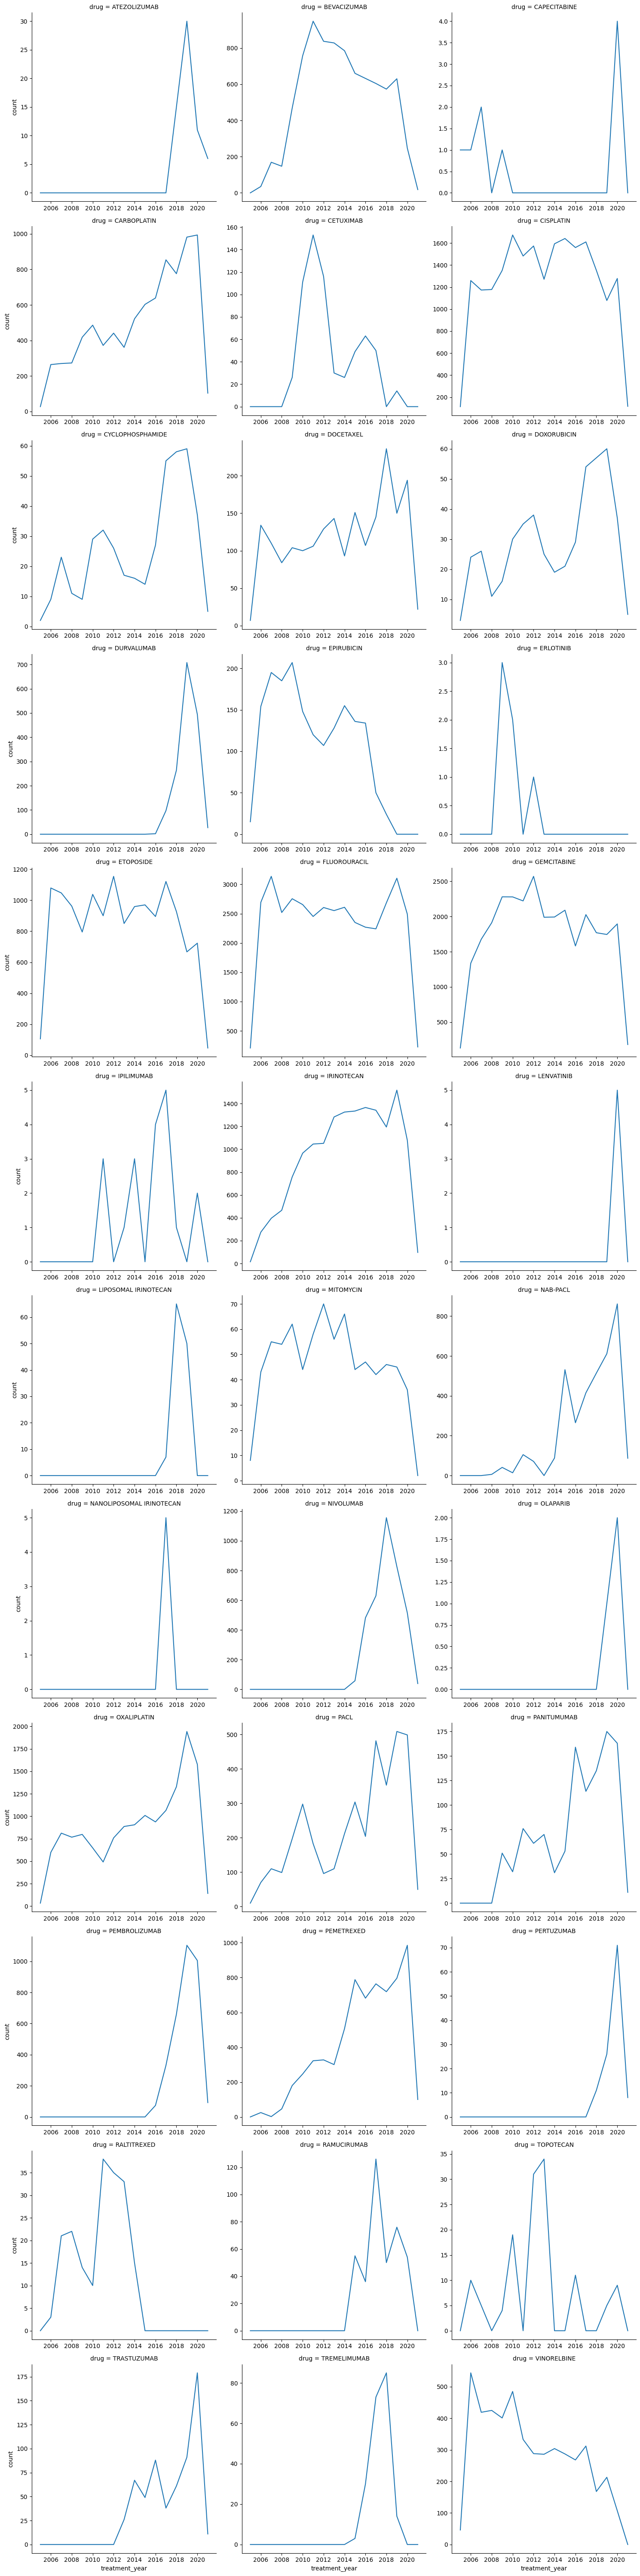

In [8]:
"""Number of drugs administered over time"""
trt['treatment_year'] = trt['treatment_date'].dt.year
cols = trt.columns
drug_cols = cols[cols.str.endswith('given_dose')]
counts = trt.groupby('treatment_year').apply(lambda g: (g[drug_cols] != 0).sum(), include_groups=False)
counts = counts.rename(columns={col: col.replace('drug_', '').replace('_given_dose', '') for col in drug_cols})
counts = counts.reset_index().melt('treatment_year', var_name='drug', value_name='count')
g = sns.relplot(
    data=counts, x='treatment_year', y='count', col='drug', col_wrap=3, kind='line', 
    facet_kws={'sharex': False, 'sharey': False}
)

In [5]:
"""
Check the number of cases where the dose given differed from dose ordered
"""
mask = (opis['Dose_Given'] == opis['Dose_Ord'])
mask.value_counts()

True     389575
False       263
dtype: int64

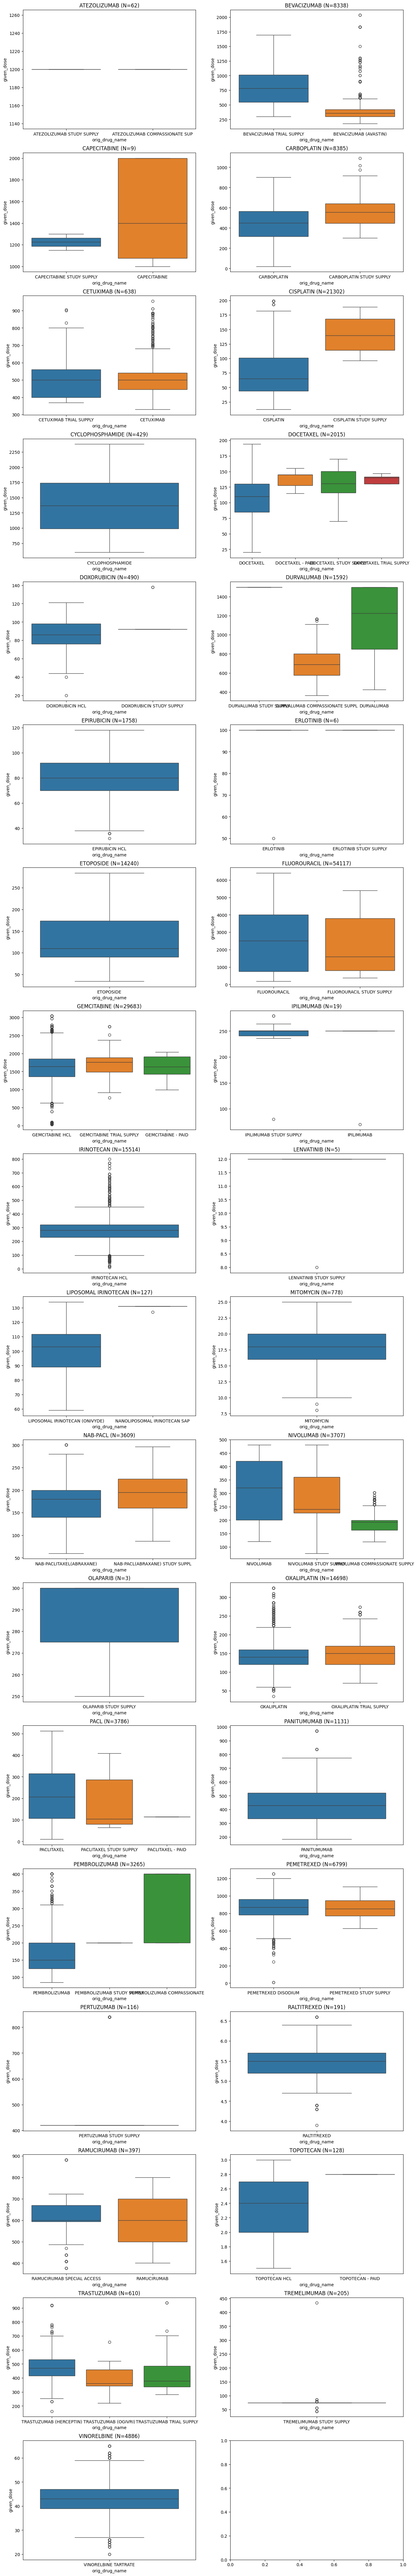

In [65]:
"""
Check out the drug groupings
"""
import logging; logging.disable(logging.CRITICAL) # temporarily disable logging

df = filter_treatment_data(opis, included_drugs, included_regimens)
nrows, ncols = df['drug_name'].nunique() // 2 + 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8*ncols, 6*nrows))
axes = axes.flatten()
for i, (drug_name, group) in enumerate(df.groupby('drug_name')):
    # if group['orig_drug_name'].nunique() < 2: continue
    palette = sns.color_palette('husl', group['orig_drug_name'].nunique())
    sns.boxplot(data=group, x="orig_drug_name", y="given_dose", ax=axes[i], hue="orig_drug_name")
    axes[i].set(title=f'{drug_name} (N={len(group)})')

In [ ]:
# how often regimen_dose is NaN, which leads to %_ideal_dose to be NaN too
def helper(g):
    N = g['regimen_dose'].isna().sum()
    return f"{N} ({N/len(g)*100:.2f}%)"
df.groupby('drug_name').apply(helper, include_groups=False)

drug_name
ATEZOLIZUMAB              0 (0.00%)
BEVACIZUMAB              85 (1.02%)
CAPECITABINE             1 (11.11%)
CARBOPLATIN              96 (1.14%)
CETUXIMAB                 1 (0.16%)
CISPLATIN               108 (0.51%)
CYCLOPHOSPHAMIDE          0 (0.00%)
DOCETAXEL                26 (1.29%)
DOXORUBICIN               0 (0.00%)
DURVALUMAB               22 (1.38%)
EPIRUBICIN                4 (0.23%)
ERLOTINIB                 0 (0.00%)
ETOPOSIDE                46 (0.32%)
FLUOROURACIL            231 (0.43%)
GEMCITABINE             172 (0.58%)
IPILIMUMAB                1 (5.26%)
IRINOTECAN               20 (0.13%)
LENVATINIB                0 (0.00%)
LIPOSOMAL IRINOTECAN      0 (0.00%)
MITOMYCIN                 0 (0.00%)
NAB-PACL                 16 (0.44%)
NIVOLUMAB                54 (1.46%)
OLAPARIB                  0 (0.00%)
OXALIPLATIN              65 (0.44%)
PACL                      4 (0.11%)
PANITUMUMAB               0 (0.00%)
PEMBROLIZUMAB             0 (0.00%)
PEMETREXED        

## Days Since Prev Session

In [6]:
# check the number of cases for each days since prev session
pd.concat([
    trt['days_since_last_treatment'].value_counts(),
    trt.groupby('days_since_last_treatment').apply(lambda g: g['mrn'].nunique())
], axis=1, keys=['Sessions', 'Patients']).sort_index().head(n=100)

Sessions  Patients
1.0       17404      2241
2.0         271       223
3.0        1923       841
4.0         747       277
5.0          75        73
6.0         445       388
7.0       22523      4379
8.0         771       579
9.0         121       104
10.0         91        86
11.0        124       120
12.0        315       279
13.0       1508      1070
14.0      26863      4373
15.0       1461      1126
16.0        584       523
17.0        512       449
18.0        399       364
19.0        753       509
20.0        984       881
21.0      13083      4492
22.0       1137      1008
23.0        542       514
24.0        828       704
25.0        890       824
26.0        937       608
27.0        560       521
28.0       5401      2238
29.0        474       429
30.0        211       202
31.0        286       275
32.0        246       229
33.0        161       157
34.0        136       133
35.0        840       710
36.0        133       132
37.0         81        81
38.0         77        76
39.0         83        83
40.0         68        66
41.0         83        83
42.0        786       574
43.0         68        68
44.0         49        49
45.0         42        42
46.0         65        65
47.0         31        31
48.0         54        54
49.0        231       223
50.0         38        37
51.0         26        26
52.0         31        31
53.0         28        27
54.0         22        22
55.0         40        40
56.0        223       198
57.0         41        41
58.0         22        22
59.0         21        21
60.0         22        22
61.0         21        21
62.0         30        30
63.0        128       125
64.0         32        32
65.0          6         6
66.0         10        10
67.0         21        21
68.0         18        18
69.0         25        25
70.0        112       107
71.0         25        25
72.0          8         8
73.0         11        11
74.0         18        18
75.0         12        12
76.0         22        22
77.0         80        80
78.0         17        17
79.0         13        13
80.0         11        11
81.0         10        10
82.0         15        15
83.0         24        24
84.0         92        88
85.0         20        20
86.0         14        14
87.0         13        13
88.0         15        15
89.0          9         9
90.0         17        17
91.0         70        70
92.0         25        24
93.0          8         8
94.0         14        14
95.0         12        12
96.0         14        14
97.0         16        16
98.0         58        58
99.0         14        14
100.0        13        13

# Emerg Data

In [4]:
er_visit = pd.read_parquet(f'{ROOT_DIR}/data/raw/ER.parquet.gzip')
erv = pd.read_parquet(f'{ROOT_DIR}/data/interim/emergency_room_visit.parquet.gzip')

## ER Reason

In [5]:
erv['CEDIS_complaint'].value_counts().head(100)

CEDIS_complaint
Abdominal pain                                         4081
Shortness of breath-SOB                                2804
General weakness                                       2266
Chest Pain-cardiac features                            1701
Medical device problem                                 1537
Fever unspecified                                      1457
Direct referral for consultation (Z71.9),              1116
Abnormal lab values                                     837
Nausea and/or vomiting                                  797
Back pain                                               784
Localized swelling/redness                              521
Blood in stool/Melena                                   505
Lower extremity pain                                    488
Shortness of breath (SOB)                               460
Lower extremity                                         458
Fever                                                   428
Headache                

In [10]:
# how often do CEDIS_complaint and chief_complaint deviate
mask = erv['CEDIS_complaint'].str.lower() == erv['chief_complaint'].str.lower()
mask.value_counts()

False    36571
True     12403
Name: count, dtype: int64

# Death Data

In [8]:
cancer_registry_ddates = pd.read_parquet('./data/raw/cancer_registry.parquet.gzip')
epr_death_ddates = pd.read_parquet('./data/raw/death_dates.parquet.gzip')
cancer_registry_ddates.rename(columns={'MEDICAL_RECORD_NUMBER': 'mrn', 'DATE_OF_DEATH': 'date_of_death'}, inplace=True)
epr_death_ddates.rename(columns={'MEDICAL_RECORD_NUMBER': 'mrn', 'DATE_OF_DEATH': 'date_of_death'}, inplace=True)
epr_death_ddates['date_of_death'] = pd.to_datetime(epr_death_ddates['date_of_death'], format='%d%b%Y:%H:%M:%S')
assert epr_death_ddates['date_of_death'].notnull().all() and not epr_death_ddates['mrn'].duplicated().any()
df = pd.merge(cancer_registry_ddates, epr_death_ddates, on ='mrn', how='left', suffixes=('_cr', '_epr'))

In [9]:
mask1 = df[['date_of_death_cr', 'date_of_death_epr']].notnull().all(axis=1)
mask2 = df['date_of_death_cr'].dt.date != df['date_of_death_epr']
tmp = df[mask1 & mask2]
diff = tmp['date_of_death_cr'] - tmp['date_of_death_epr']
mask = diff.dt.days.abs() > 3
conflicting_death_dates = tmp[mask].groupby('mrn')[['date_of_death_cr', 'date_of_death_epr']].first()
print(f'There are {len(conflicting_death_dates)} patients with conflicting death dates greater than 3 days')
mask = df['date_of_death_epr'].notnull() & df['date_of_death_cr'].isnull()
print(f'There are {sum(mask)} patients with death dates in the EPR death dataset but not in the Cancer Registry dataset')
mask = df['date_of_death_cr'].notnull() & df['date_of_death_epr'].isnull()
print(f'There are {sum(mask)} patients with death dates in the Cancer Registry dataset but not in EPR death dataset')

There are 333 patients with conflicting death dates greater than 3 days
There are 151 patients with death dates in the EPR death dataset but not in the Cancer Registry dataset
There are 10910 patients with death dates in the Cancer Registry dataset but not in EPR death dataset


# Demographic / Cancer Data

In [26]:
dmg = pd.read_parquet(f'{ROOT_DIR}/data/interim/demographic.parquet.gzip')
canc_cols = [col for col in dmg.columns if col.startswith('cancer_site')]

In [27]:
# number of patients diagnosed with multiple cancers
mask = dmg[canc_cols].notnull().sum(axis=1) > 1
mask.value_counts()

False    51159
True      1209
Name: count, dtype: int64

In [28]:
# number of patients diagnosed with two different cancers on the same day
mask = dmg[cols].nunique(axis=1) != dmg[cols].notnull().sum(axis=1)
mask.value_counts()

False    52259
True       109
Name: count, dtype: int64

# Radiology Data

## Duplicate reports

In [4]:
reports = get_radiology_data(mrn_map, data_dir=f'{ROOT_DIR}/data/raw', drop_duplicates=False)

In [5]:
mask = reports.duplicated(subset=['mrn', 'raw_text', 'proc_name'], keep=False)
print(f'{sum(mask)} duplicated reports with same proc_name found out of {len(mask)} reports')
mask = reports.duplicated(subset=['mrn', 'raw_text'], keep=False)
print(f'{sum(mask)} duplicated reports found out of {len(mask)} reports')
duplicated_reports = reports[mask].sort_values(by='epr_datetime')

122351 duplicated reports with same proc_name found out of 263097 reports
165535 duplicated reports found out of 263097 reports


In [5]:
time_diffs = []
for (mrn, text), g in tqdm(duplicated_reports.groupby(['mrn', 'raw_text'])):
    time_diff = g['epr_datetime'] - g['epr_datetime'].iloc[0]
    time_diff = time_diff[time_diff != pd.Timedelta(seconds=0)]
    time_diffs.append(time_diff[1:])

100%|██████████| 72769/72769 [00:10<00:00, 6902.04it/s]


In [11]:
time_diffs = pd.concat(time_diffs)
bins = [
    pd.Timedelta(minutes=0),
    pd.Timedelta(hours=1),
    pd.Timedelta(hours=2),
    pd.Timedelta(hours=5),
    pd.Timedelta(hours=24),
    pd.Timedelta(days=2),
    pd.Timedelta(days=5),
    pd.Timedelta(days=5000),
]
labels = [
    '0-1hour',
    '1-2hours', 
    '2-5hours', 
    '5-24hours', 
    '1-2days', 
    '2-5days', 
    '5days+'
]
time_diffs = pd.cut(time_diffs, bins=bins, labels=labels)

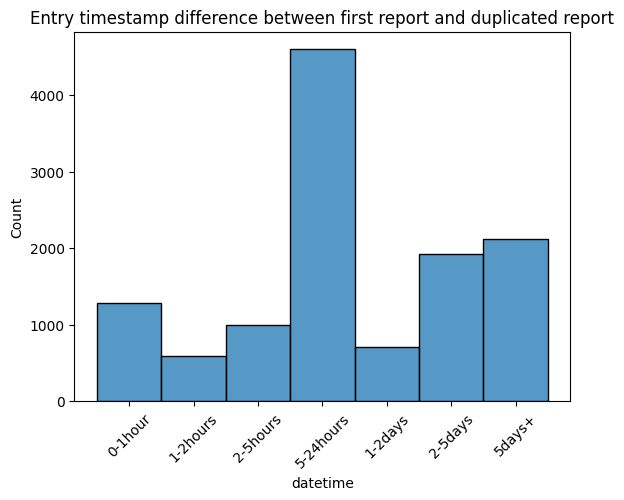

In [ ]:
ax = sns.histplot(data=time_diffs)
ax.set(title='Entry timestamp difference between first report and duplicated report')
ax.tick_params(axis='x', rotation=45)

100%|██████████| 72769/72769 [00:02<00:00, 28239.39it/s]


<Axes: >

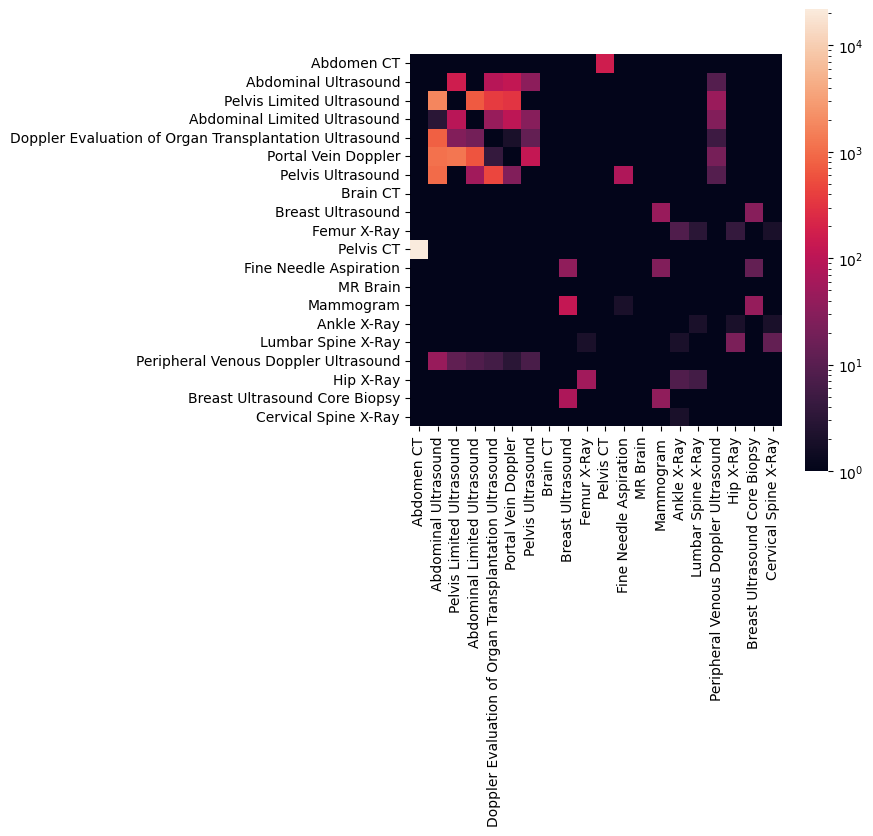

In [ ]:
paired_proc_names = duplicated_reports['proc_name'].unique()
paired_proc_names = pd.DataFrame(1, columns=paired_proc_names, index=paired_proc_names).to_dict()
for (mrn, text), g in tqdm(duplicated_reports.groupby(['mrn', 'raw_text'])):
    proc_names = g['proc_name'].unique()
    for i, proc_name1 in enumerate(proc_names):
        for proc_name2 in proc_names[i+1:]:
            paired_proc_names[proc_name1][proc_name2] += 1
paired_proc_names = pd.DataFrame(paired_proc_names)

drop = [name for name in paired_proc_names if all(paired_proc_names[name] == 0) & all(paired_proc_names.loc[name] == 0)]
paired_proc_names = paired_proc_names.drop(index=drop, columns=drop)

# drop = [name for name in paired_proc_names if 'CT' not in name]
# paired_proc_names = paired_proc_names.drop(index=drop, columns=drop)

keep = paired_proc_names.sum().sort_values(ascending=False).index[:20]
paired_proc_names = paired_proc_names.loc[keep, keep]

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(paired_proc_names, square=True, xticklabels=True, yticklabels=True, ax=ax, norm=LogNorm())

# No Overlaps

In [5]:
def get_overlap_numbers(a, b, a_name, b_name):
    set_a, set_b = set(a), set(b)
    return pd.DataFrame(
        data=[len(set_a - set_b), len(set_a & set_b), len(set_b - set_a)],
        index=[f'Only {a_name}', 'In both', f'Only {b_name}']
    ).T

In [25]:
biochem = pd.read_parquet(f'{ROOT_DIR}/data/raw/biochemistry.parquet.gzip')
hema = pd.read_parquet(f'{ROOT_DIR}/data/raw/hematology.parquet.gzip')
mrn_map = pd.read_csv(f'{ROOT_DIR}/data/external/MRN_map.csv')

In [32]:
# double checking the mrn mapping is unique
assert mrn_map['RESEARCH_ID'].nunique() == mrn_map['PATIENT_MRN'].nunique() == len(mrn_map)
print(f'{mrn_map["RESEARCH_ID"].nunique()} patients in the MRN map')
# all patients in biochemistry and hematology have a MRN (overlaps with MRN map)
assert biochem['patientid'].isin(mrn_map['RESEARCH_ID']).all()
assert hema['patientid'].isin(mrn_map['RESEARCH_ID']).all()
get_overlap_numbers(biochem['patientid'], hema['patientid'], 'biochem', 'hema')

43271 patients in the MRN map


Only biochem  In both  Only hema
0           356    33242        200

In [6]:
trt = pd.read_parquet(f'{ROOT_DIR}/data/interim/treatment.parquet.gzip')
dmg = pd.read_parquet(f'{ROOT_DIR}/data/interim/demographic.parquet.gzip')
get_overlap_numbers(trt['mrn'], dmg['mrn'], 'treatment', 'demographic')

Only treatment  In both  Only demographic
0             975     9297             43071

In [59]:
trt = pd.read_parquet(f'{ROOT_DIR}/data/interim/treatment.parquet.gzip')
lab = pd.read_parquet(f'{ROOT_DIR}/data/interim/lab.parquet.gzip')
get_overlap_numbers(trt['mrn'], lab['mrn'], 'treatment', 'laboratory')

Only treatment  In both  Only laboratory
0            2598     7674            26033

<Axes: xlabel='treatment_date', ylabel='Count'>

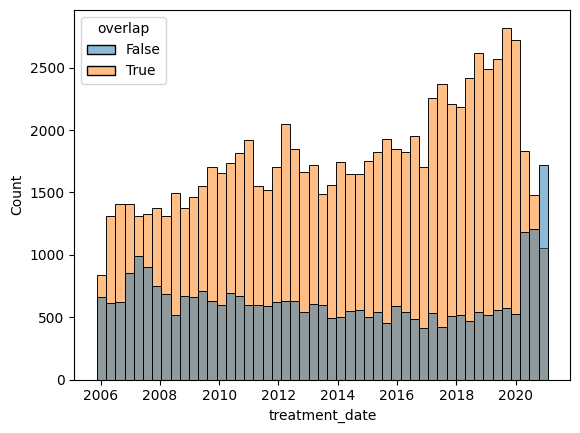

In [60]:
df = trt[['treatment_date']].copy()
df['overlap'] = trt['mrn'].isin(lab['mrn'])
sns.histplot(data=df, x='treatment_date', hue='overlap')

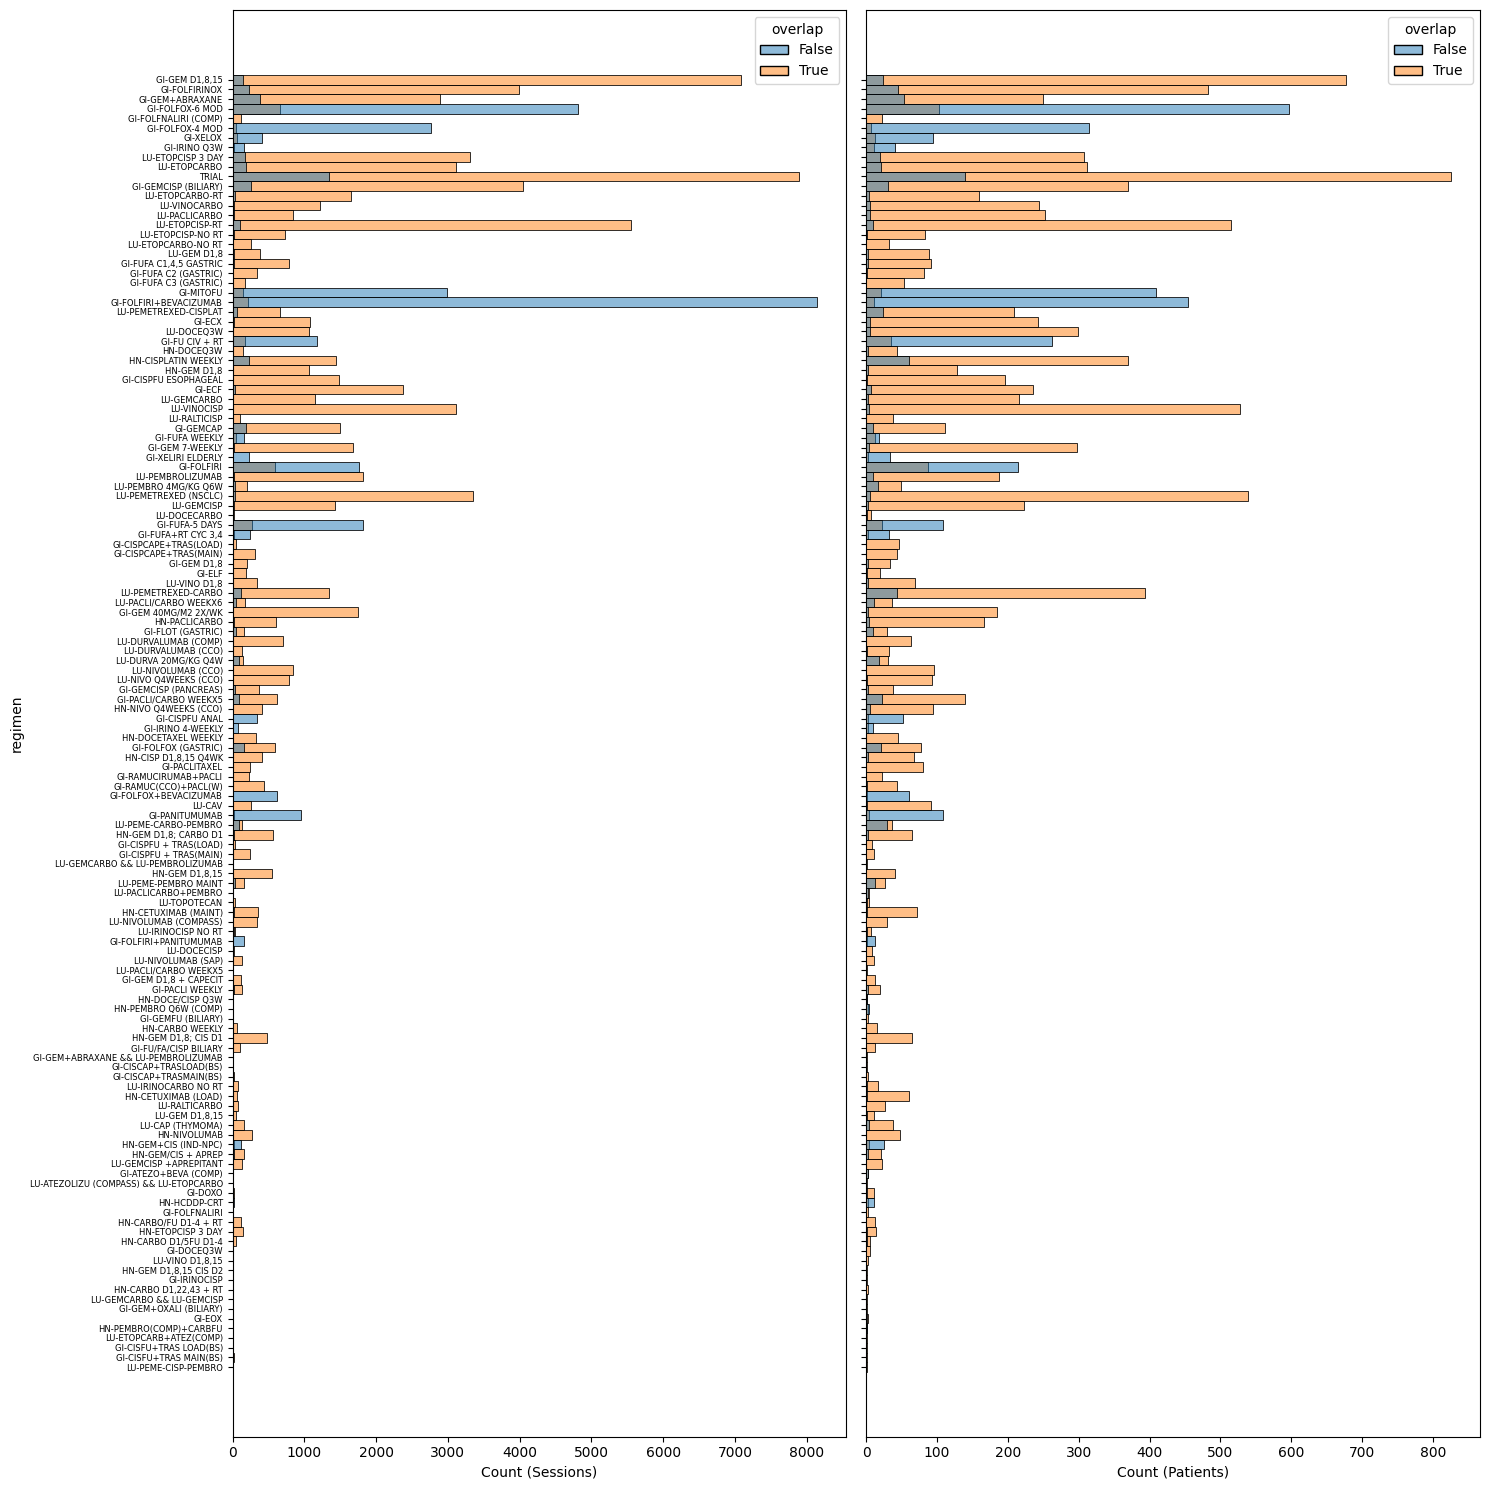

In [115]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))

df = trt[['regimen', 'mrn']].copy()
df['overlap'] = df['mrn'].isin(lab['mrn'])
sns.histplot(data=df, y='regimen', hue='overlap', ax=ax1)
ax1.set(xlabel='Count (Sessions)')
ax1.yaxis.set_tick_params(labelsize=6)

df = df.drop_duplicates(subset=['regimen', 'mrn'])
sns.histplot(data=df, y='regimen', hue='overlap', ax=ax2)
ax2.set(xlabel='Count (Patients)', ylabel=None)
ax2.yaxis.set_tick_params(labelleft=False)

plt.tight_layout()

In [169]:
df = pd.read_parquet(f'{ROOT_DIR}/data/processed/treatment_centered_clinical_dataset.parquet.gzip')
lab = pd.read_parquet(f'{ROOT_DIR}/data/interim/lab.parquet.gzip')
get_overlap_numbers(df['mrn'], lab['mrn'], 'final dataset', 'laboratory')

Only final dataset  In both  Only laboratory
0                1976     7321            26386

<Axes: xlabel='Proportion', ylabel='Cancer Site'>

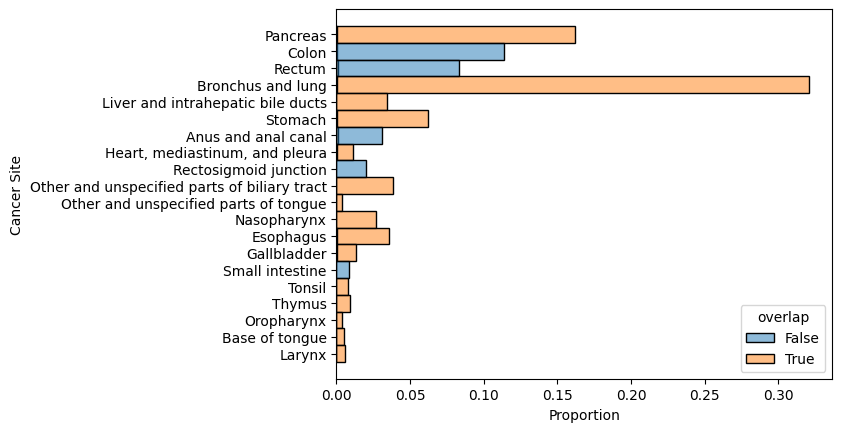

In [145]:
from ml_common.constants import CANCER_CODE_MAP
cancer_site_cols = df.columns[df.columns.str.contains("cancer_site")]
df["cancer_site"] = df[cancer_site_cols].apply(lambda mask: ", ".join(cancer_site_cols[mask].str.removeprefix("cancer_site_")), axis=1)
df["Cancer Site"] = df["cancer_site"].replace(CANCER_CODE_MAP)
top_20_cancer_sites = df['Cancer Site'].value_counts().index[:20]
df = df[df['Cancer Site'].isin(top_20_cancer_sites)]
df['overlap'] = df['mrn'].isin(lab['mrn'])
sns.histplot(data=df, y='Cancer Site', hue='overlap', stat='proportion')

In [151]:
trt = pd.read_parquet(f'{ROOT_DIR}/data/interim/treatment.parquet.gzip')
symp = pd.read_parquet(f'{ROOT_DIR}/data/interim/symptom.parquet.gzip')
get_overlap_numbers(trt['mrn'], symp['mrn'], 'treatment', 'symptom')

Only treatment  In both  Only symptom
0            3117     7155         22350

<Axes: xlabel='treatment_date', ylabel='Count'>

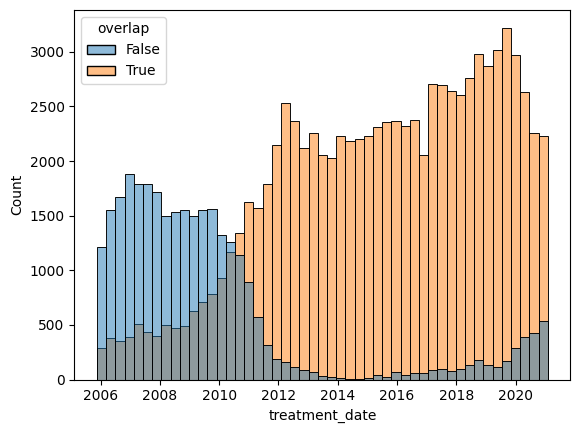

In [154]:
df = trt[['treatment_date']].copy()
df['overlap'] = trt['mrn'].isin(symp['mrn'])
sns.histplot(data=df, x='treatment_date', hue='overlap')